# Train surrogate model

With the previous data, train a surrogate model (gaussian process or NN)

## Model training

We use data from a file or a function generation to train a perception surrogate $g(\Delta x)$.
In this case $\Delta x$ is defined as the relative position (distance) between a tree and the drone: $\Delta x = \| x - t_i \|$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import torch
import os
import csv
import random

import numpy as np
from scipy.stats import norm  # For Gaussian PDF


def load_data(polar=False, fixedView=False, ripe=True, n_input=3, subset_ratio=1.0, augment_data=True):
    # Get the current working directory if __file__ is not available
    script_dir = os.getcwd()  # Use current working directory as fallback

    # Define the base directory for datasets
    base_dir = os.path.join(script_dir, "datasets")  # Adjust subdirectory name as needed
    
    # Adjust paths based on parameters
    base_dir = os.path.join(base_dir, "polar" if polar else "cartesian")
    base_dir = os.path.join(base_dir, "fixed_view" if fixedView else "variable_view")
    base_dir = os.path.join(base_dir, "ripe" if ripe else "raw")
    
    # Output CSV filename
    output_csv_filename = 'SurrogateDatasetCNN.csv'

    def find_latest_folder(base_dir):
        """Finds the latest dated folder in the base directory."""
        # List all subdirectories in the base_dir
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        
        # Sort the directories by their modified time in reverse (latest first)
        latest_folder = max(subdirs, key=lambda d: os.path.getmtime(os.path.join(base_dir, d)))
        return os.path.join(base_dir, latest_folder)

    # Find the latest dataset folder
    latest_dataset_folder = find_latest_folder(base_dir=base_dir)
    
    # Create the full path to the CSV file
    DATA_PATH = os.path.join(latest_dataset_folder, output_csv_filename)
    print(f"Loading data from: {DATA_PATH}")
    
    # Initialize lists to store data
    X = []  
    Y = []
    
    # Read the CSV file
    with open(DATA_PATH, 'r') as infile:
        data = csv.reader(infile)
        next(data)  # Skip the header
        for row in data:
            a, b, c, _, value_raw, value_ripe, _ = map(float, row)
            
            # Process input features
            if n_input == 3:
                # Normalize angle to [-π, π]
                X.append([a, b, c])
            else:
                X.append([a, b])
            
            # Scale the target value
            Y.append((value_ripe if ripe else (value_raw)) - 0.5)
    
    # Convert lists to numpy arrays
    X_np = np.array(X)
    Y_np = np.array(Y)
    
    # Randomly sample a subset of the data based on the subset_ratio
    if subset_ratio < 1.0:
        num_samples = int(len(X_np) * subset_ratio)
        indices = np.random.choice(len(X_np), num_samples, replace=False)
        X_np = X_np[indices]
        Y_np = Y_np[indices]
    
    def generate_surrogate_augmented_data(X, num_samples):
        x_min = (np.sqrt(X[:, 0]**2 + X[:, 1]**2)).min()
        x_max = (np.sqrt(X[:, 0]**2 + X[:, 1]**2)).max()
        yaw_values = [30, -30, 60, -60, 90, -90, 180, -180]
        
        synthetic_X = []
        synthetic_Y = []
        
        for _ in range(num_samples):
            theta = random.uniform(-np.pi, np.pi)
            r = random.choice([random.uniform(0, x_min), random.uniform(x_max, x_max +5)])
            a = r * np.cos(theta) 
            b = r * np.sin(theta)
            c = np.radians(random.choice(yaw_values))
            value = 0.0
            synthetic_X.append([a, b, c])
            synthetic_Y.append(value)

        return np.array(synthetic_X), np.array(synthetic_Y)

    if not augment_data: return  torch.tensor(X_np, dtype=torch.float), torch.tensor(Y_np, dtype=torch.float)
    # Generate augmented (synthetic) data
    synthetic_X, synthetic_Y = generate_surrogate_augmented_data(X_np, int(len(X_np)*0.2))
    
    # Concatenate the original and synthetic datasets along the first axis (rows)
    X_extended = np.concatenate((X_np, synthetic_X), axis=0)
    Y_extended = np.concatenate((Y_np, synthetic_Y), axis=0)
    
    # Convert the extended arrays to PyTorch tensors
    X_tensor = torch.tensor(X_extended, dtype=torch.float)
    Y_tensor = torch.tensor(Y_extended, dtype=torch.float)
    return X_tensor, Y_tensor

def fake_confidence(drone_pos, tree_pos, fov=40, dist_threshold = 5):
    """
    Simulates the confidence output of the NN.
    """
    direction = tree_pos - drone_pos[:2]
    distance = np.sqrt(np.sum(direction**2))
    result = np.full_like(distance, 0.5)
    
    
    theta = drone_pos[2]
    drone_forward = np.array([np.cos(theta), np.sin(theta)])
    n_direction = direction / distance
    ang_fov_tree = n_direction.T @ drone_forward  # Dot product (cos(angolo))
    fov_threshold = np.cos(np.deg2rad(fov))
    
    if distance < 0.2 or distance > dist_threshold:
        result = 0.5
    elif ang_fov_tree >= fov_threshold and np.cos(np.arctan2(direction[1], direction[0])) > 0:  # Drone is facing the tree
        result = norm.pdf(distance, loc=3.5, scale=2.0) + 0.5
    return result

def generate_fake_dataset(
    samples_xy, 
    samples_yaw, 
    x_dimension, 
    use_fov=True,
    x_low=-8,          # Lower bound for drone X position
    x_high=8,          # Upper bound for drone X position
    y_low=-8,          # Lower bound for drone Y position
    y_high=8,          # Upper bound for drone Y position
    tree_low=-8,       # Lower bound for tree position
    tree_high=8        # Upper bound for tree position
):
    synthetic_X = []
    synthetic_Y = []
    
    # Define ranges for drone positions with parameterized bounds
    x_range = np.linspace(x_low, x_high, samples_xy)
    y_range = np.linspace(y_low, y_high, samples_xy)
    yaw_range = np.linspace(-np.pi, np.pi, samples_yaw)

    for x in x_range:
        for y in y_range:
            if use_fov:
                for yaw in yaw_range:
                    tree_pos = np.random.uniform(low=tree_low, high=tree_high, size=(1, 2))
                    drone_pos = np.array([x, y, yaw])
                    value = fake_confidence(drone_pos, tree_pos.flatten())
                    synthetic_X.append(
                        np.concatenate((drone_pos[:x_dimension], tree_pos.flatten()))
                    )
                    synthetic_Y.append(value)
            else:
                tree_pos = np.random.uniform(low=tree_low, high=tree_high, size=(1, 2))
                drone_pos = np.array([x, y, np.arctan2(-y, -x)])
                value = fake_confidence(drone_pos, tree_pos.flatten())
                synthetic_X.append(
                    np.concatenate((drone_pos[:x_dimension], tree_pos.flatten()))
                )
                synthetic_Y.append(value)
    
    return torch.Tensor(np.array(synthetic_X)), torch.Tensor(np.array(synthetic_Y))

In [3]:
hidden_size = 64
hidden_layers_dim = 8

# Simple NN
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = torch.nn.Linear(input_dim, hidden_size)

        hidden_layers = []
        for i in range(hidden_layers_dim):
            hidden_layers.append(torch.nn.Linear(hidden_size, hidden_size))

        self.hidden_layer = torch.nn.ModuleList(hidden_layers)
        self.out_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):

        x = self.input_layer(x)
        for layer in self.hidden_layer:
            x = torch.tanh(layer(x))
        x = self.out_layer(x)
        return x



## Main Parameters

In [4]:
train = True
batch_size = 1
lr = 1e-4
epochs = 10
validation_split = 0.3
nn_input_dim = 3
fixedView = False
is_ripe = False

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime

X, Y = load_data(fixedView=fixedView, ripe=is_ripe)

print("Features shape:", X.shape)
print("Targets shape:", Y.shape)

if train:
    # Update input dimension to 4 for the new feature set
    nn_input_dim = 4  
    base_model_dir = os.path.join(f"saved_models_{nn_input_dim}d", 'unity_dataset')
    os.makedirs(base_model_dir, exist_ok=True)
    base_model_dir = os.path.join(base_model_dir, 'ripe' if is_ripe else 'raw')
    os.makedirs(base_model_dir, exist_ok=True)

    # Create a new folder with the current timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_model_dir = os.path.join(base_model_dir, timestamp)
    os.makedirs(run_model_dir, exist_ok=True)
    print("Models will be saved in:", run_model_dir)

    # Prepare dataset:
    # Assume that the last column in X represents an angle.
    # We take the first two columns as-is and add two new columns for sin and cos of the angle.
    angles = X[:, -1]                # Extract angle values from the last column
    angle_sin = np.sin(angles)         # Compute sine of the angles
    angle_cos = np.cos(angles)         # Compute cosine of the angles

    # Construct the new feature matrix: first two columns + sin(angle) and cos(angle)
    X_new = np.column_stack((X[:, :2], angle_sin, angle_cos))
    X = X_new

    # Convert to tensors and prepare the dataset
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                            torch.tensor(Y, dtype=torch.float32))
    # Train-validation split
    num_train_samples = int((1 - validation_split) * len(dataset))
    num_val_samples = len(dataset) - num_train_samples
    train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model with 4 input features
    import l4casadi as l4c
    model = l4c.naive.MultiLayerPerceptron(4, 64, 1, 8, 'Tanh')
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(model)

    # Set up TensorBoard logging
    log_dir = f"runs/fcn_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir)

    # Training loop with validation
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (x_batch, y_batch) in enumerate(val_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        
        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = os.path.join(run_model_dir, f"best_model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path}")

    writer.close()


Loading data from: /home/pantheon/drea/neural_mpc/datasets/cartesian/variable_view/raw/2025-03-26_01-17-32/SurrogateDatasetCNN.csv
Features shape: torch.Size([3888, 3])
Targets shape: torch.Size([3888])
Models will be saved in: saved_models_4d/unity_dataset/raw/20250327_162337
MultiLayerPerceptron(
  (input_layer): Linear(in_features=4, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-6): 7 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (act): Tanh()
)


/tmp/ipykernel_1134717/4206418136.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/pantheon/mpc-drone/ros/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [1/10] | Train Loss: 0.0007 | Val Loss: 0.0007
Model saved to saved_models_4d/unity_dataset/raw/20250327_162337/best_model_epoch_1.pth
Epoch [2/10] | Train Loss: 0.0006 | Val Loss: 0.0007
Model saved to saved_models_4d/unity_dataset/raw/20250327_162337/best_model_epoch_2.pth
Epoch [3/10] | Train Loss: 0.0006 | Val Loss: 0.0007
Model saved to saved_models_4d/unity_dataset/raw/20250327_162337/best_model_epoch_3.pth
Epoch [4/10] | Train Loss: 0.0006 | Val Loss: 0.0007
Epoch [5/10] | Train Loss: 0.0006 | Val Loss: 0.0006
Model saved to saved_models_4d/unity_dataset/raw/20250327_162337/best_model_epoch_5.pth
Epoch [6/10] | Train Loss: 0.0006 | Val Loss: 0.0007
Epoch [7/10] | Train Loss: 0.0006 | Val Loss: 0.0006
Model saved to saved_models_4d/unity_dataset/raw/20250327_162337/best_model_epoch_7.pth
Epoch [8/10] | Train Loss: 0.0006 | Val Loss: 0.0006
Epoch [9/10] | Train Loss: 0.0006 | Val Loss: 0.0007
Epoch [10/10] | Train Loss: 0.0006 | Val Loss: 0.0006
Model saved to saved_models_4

In [6]:
import re
def get_latest_best_model(nn_input_dim, ripe):
    # Base directory to save models
    base_model_dir = os.path.join(f"saved_models_{nn_input_dim}d", 'unity_dataset')
    base_model_dir = os.path.join(base_model_dir, 'ripe' if ripe else 'raw')
    # Find the latest best model file
    # List the run directories (assumed to be named with timestamps, e.g., "20250204_153045")
    run_dirs = [d for d in os.listdir(base_model_dir) if os.path.isdir(os.path.join(base_model_dir, d))]
    if not run_dirs:
        raise ValueError(f"No run directories found in: {base_model_dir}")
    
    # Select the latest run directory (using lexicographical order assuming proper timestamp formatting)
    latest_run = max(run_dirs)
    latest_run_dir = os.path.join(base_model_dir, latest_run)
    
    # Within the latest run folder, find all files matching the best model naming pattern
    best_model_files = [
        f for f in os.listdir(latest_run_dir)
        if re.match(r"best_model_epoch_(\d+)\.pth", f)
    ]
    if not best_model_files:
        raise ValueError(f"No best model files found in: {latest_run_dir}")
    
    # Pick the file with the highest epoch number.
    latest_model = max(
        best_model_files,
        key=lambda f: int(re.match(r"best_model_epoch_(\d+)\.pth", f).group(1))
    )
    
    loaded_model = os.path.join(latest_run_dir, latest_model)
    print(f'Loaded model: {loaded_model}')
    return loaded_model

## Training results:

In [7]:
# Create subplots
fig = make_subplots(
    rows=1, cols=2,  # 1 row, 2 columns
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],  # Both subplots are 3D scatter plots
    subplot_titles=("Ground Truth", "Predicted")  # Titles for each subplot
)

# Generate fake dataset with 3 columns: x, y, yaw
X_nn, _ = generate_fake_dataset(
    samples_xy=80, 
    samples_yaw=1, 
    x_dimension=3,
    use_fov=False,
    x_low=-8,        # Drone X ranges from -8 to 8
    x_high=8,
    y_low=-8,        # Drone Y ranges from -8 to 8
    y_high=8,
    tree_low=0,     
    tree_high=0
)

# Plot Ground Truth using training data (assuming X and Y are from your training set)
fig.add_trace(
    go.Scatter3d(
        z=Y.flatten(), 
        x=X[:, 0], 
        y=X[:, 1], 
        name='Ground Truth',
        mode='markers',
        marker=dict(
            color=Y.flatten(),  # Color based on z values
            colorscale='Viridis',     # Use Viridis color map
            colorbar=dict(title='Z Value'),  # Add color bar
            size=5,                   # Marker size
            opacity=0.8               # Marker opacity
        )
    ),
    row=1, col=1
)

# Initialize model for 4 inputs (x, y, sin(yaw), cos(yaw))
import l4casadi as l4c
model = l4c.naive.MultiLayerPerceptron(4, 64, 1, 8, 'Tanh') 
model.load_state_dict(torch.load(get_latest_best_model(nn_input_dim, ripe=is_ripe)))  # Ensure nn_input_dim is 4
model.eval()

# Transform the fake dataset: convert yaw (3rd col) into sin and cos, and keep x, y as-is.
# X_nn originally has shape (N, 3): [x, y, yaw]
yaw_angles = X_nn[:, 2]
X_nn_transformed = np.column_stack((
    X_nn[:, :2],          # x and y remain unchanged
    np.sin(yaw_angles),   # new third column: sin(yaw)
    np.cos(yaw_angles)    # new fourth column: cos(yaw)
))

# Model prediction using the transformed features
with torch.no_grad():
    x_tensor = torch.tensor(X_nn_transformed, dtype=torch.float32)
    y_test = model(x_tensor).detach().numpy()

# Add predicted trace to the second subplot using x and y from the original X_nn for visualization
fig.add_trace(
    go.Scatter3d(
        z=y_test.flatten(),
        x=X_nn[:, 0],
        y=X_nn[:, 1],
        name='Predicted',
        mode='markers',
        marker=dict(
            color=y_test.flatten(),  # Color based on predicted z values
            colorscale='Viridis',     # Use Viridis color map
            colorbar=dict(title='Z Value'),  # Add color bar
            size=5,                   # Marker size
            opacity=0.8               # Marker opacity
        )
    ),
    row=1, col=2
)

# Update layout for both subplots
fig.update_layout(
    title_text="Ground Truth vs Predicted",  # Main title
    scene=dict(  # Update the first subplot's scene
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="Output"
    ),
    scene2=dict(  # Update the second subplot's scene
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="Output"
    ),
    showlegend=False  # Hide legend for clarity
)

fig.show()
fig.write_html('nn_surrogate_train_test.html')


# Find the index of the maximum value in y_test and extract corresponding (x, y)
max_index = np.argmax(y_test)
x_best = X_nn[max_index, 0]
y_best = X_nn[max_index, 1]

# Vary the yaw angle values between -10 and 10 (or any desired range)
yaw_values = np.linspace(-10, 10, 200)

# Create a new input array with x_best and y_best fixed,
# and compute sin and cos for the varying yaw values
X_new = np.column_stack([
    np.full_like(yaw_values, x_best),
    np.full_like(yaw_values, y_best),
    np.sin(yaw_values),
    np.cos(yaw_values)
])

# Convert the new input array to a tensor for inference
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

# Model prediction for the new inputs
with torch.no_grad():
    y_new = model(X_new_tensor).detach().numpy()

# Create a new plot for the inference with varying yaw
fig_new = go.Figure()

# Add the trace for the new predictions (x-axis still shows the original yaw values in degrees)
fig_new.add_trace(
    go.Scatter(
        x=np.rad2deg(yaw_values),
        y=y_new.flatten(),
        mode='lines',
        name='Predicted Output',
        line=dict(color='blue', width=2)
    )
)

# Update layout for the new plot
fig_new.update_layout(
    title_text=f"Output Inference with Fixed (x, y) = ({x_best:.2f}, {y_best:.2f}) and Varying Yaw",
    xaxis_title="Yaw Angle (degrees)",
    yaxis_title="Output",
    showlegend=True
)

fig_new.show()
fig_new.write_html('nn_surrogate_varying_yaw.html')


Loaded model: saved_models_3d/unity_dataset/raw/20250327_161311/best_model_epoch_10.pth


# Define the working environment
The problem definition is as follows:

$x$ state of the robot defined by the position of the drone and its velocity [x, y ,z, vx, vy, vz]

$f(x, u)$ state transition function for the drone

$u$ acceleration commands to the drone [ax, ay, az]

$t \in T$ tree positions for the $T$ trees [[tx_1, ty_2], ... , [tx_T, ty_T]]

$\lambda$ belief for the trees maturity confidence [\lambda_1, ..., \lambda_T] (values from 0 to 1). For practicity, it can be seen as part of $x$

$z$ observation vector for the tree maturity confidence [z_1, ..., z_T] (values from 0 to 1)

$g(\Delta x)$ observation surrogate. It is applied to every tree.

$b(\lambda, z)$ bayesian update to the previous belief.

$H(\lambda)$ entropy function for the belief defined (for the case of binary distribution) as: $-\lambda \log{\lambda} - (1-\lambda) \log(1-\lambda)$.

$J(\lambda)$ the cost function of the MPC defined as: $\sum_{1, ..., n} \delta_1 H(\lambda_i) * \delta_2 \Delta x_i^2 + \delta_3 \|u\|$. They correspond to trying to reduce the entropy for each of the trees using $\Delta x_i^2$ to guide the planner when there is no observation, and reduce the control inputs.

The steps of the system are as follows:
1. Load learned $g()$ which works for one tree.
2. Initialize $x$ in a $x_0$ position, $\lambda$ with $0.5$ values for each tree, and $t$ as known.
3. Run the NMPC from $x$ for $N$ iterations. In each step:
  - Compute $\Delta x$ for each tree with the new drone $x$.
  - Get estimation from NN for each tree: $z = g(\Delta x)$.
  - Fuse the estimation in $\lambda$ for each tree: $\lambda_{k} = b(\lambda_{k-1}, z)$
4. Apply the solution from the MPC.
5. Get a real observation.
6. Integrate the real observation into $\lambda$.
7. Go back to step 3.

2.1374262888906864e-05


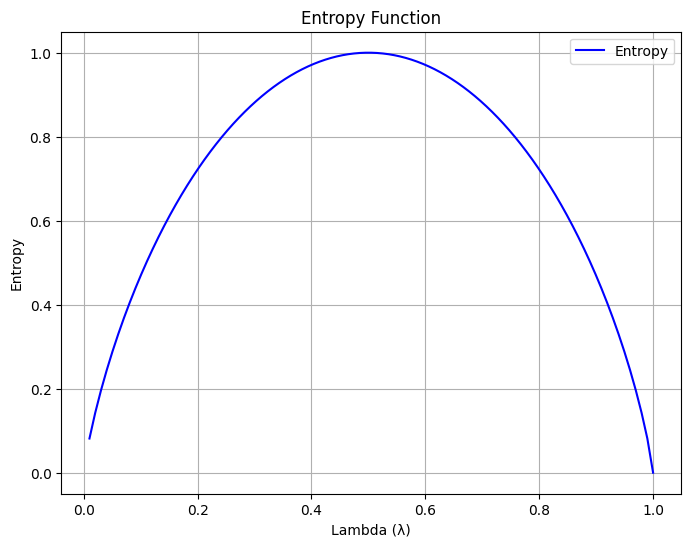

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
# Define the entropy function
def entropy(lambda_val):
    return (-(lambda_val- 1e-6) * ca.log10(lambda_val -1e-6) - (1 - lambda_val  + 1e-6) * ca.log10(1 - lambda_val  + 1e-6))/ca.log10(2)

# Generate lambda values (avoid 0 and 1 to prevent log(0) errors)
x = np.linspace(0.0, 1.00, 100)
output = []
# Compute entropy values
for i  in range(x.shape[0]):
    output.append(entropy(x[i]))

print(output[-1])
# Plot the entropy function
plt.figure(figsize=(8, 6))
plt.plot(x, output, label="Entropy", color="blue")
plt.title("Entropy Function")
plt.xlabel("Lambda (λ)")
plt.ylabel("Entropy")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
import numpy as npc
import casadi as ca
import l4casadi as l4c
import time
import torch  # Assuming you use PyTorch for your neural network

# =============================================================================
# Global Constants
# =============================================================================
T = 1.0
N = 4
dt = T / N
nx = 3  # (x, y, theta). The full state is 2*nx = 6: [x, y, theta, vx, vy, omega]

# =============================================================================
# Utility Functions
# =============================================================================
def generate_tree_positions(grid_size, spacing):
    """
    Generate tree positions on a grid and add a small offset.
    """
    x_positions = np.arange(0, grid_size[0] * spacing, spacing)
    y_positions = np.arange(0, grid_size[1] * spacing, spacing)
    xv, yv = np.meshgrid(x_positions, y_positions)
    tree_positions = np.vstack([xv.ravel(), yv.ravel()]).T
    return tree_positions + 0.1

def get_domain(tree_positions):
    """
    Returns the bounding box (lower and upper bounds) of the tree positions.
    """
    x_min = np.min(tree_positions[:, 0])
    x_max = np.max(tree_positions[:, 0])
    y_min = np.min(tree_positions[:, 1])
    y_max = np.max(tree_positions[:, 1])
    return [x_min, y_min], [x_max, y_max]

def kin_model():
    """
    Kinematic model: state X = [x, y, theta, vx, vy, omega] and control U = [ax, ay, angular_acc].
    Uses simple Euler integration.
    """
    X = ca.MX.sym('X', nx * 2)  # 6 states
    U = ca.MX.sym('U', nx)      # 3 controls
    X_next = X + dt * ca.vertcat(X[nx:], U)
    return ca.Function('F', [X, U], [X_next])

def bayes(lambda_prev, z):
    """
    Bayesian update for belief:
       lambda_next = (lambda_prev * z) / (lambda_prev * z + (1 - lambda_prev) * (1 - z))
    An epsilon term is added to avoid division by zero.
    """
    prod = lambda_prev * z
    return prod / (prod + (1 - lambda_prev) * (1 - z))

def entropy(p):
    """
    Compute the binary entropy of a probability p.
    Values are clipped to avoid log(0).
    """
    p = ca.fmin(p, 1 - 1e-6)
    return (-p * ca.log10(p) - (1 - p) * ca.log10(1 - p))/ca.log10(2)


# =============================================================================
# Modified MPC Optimization Function
# =============================================================================
def mpc_opt(g_nn, trees, lb, ub, x0, lambda_vals, entropy_horizon, steps=10):
    """
    Set up and solve the MPC optimization problem with the following modifications:
      - The robot moves according to the kinematic model.
      - Only positions and translational velocities are constrained (orientation is free).
      - A collision-avoidance (inequality) constraint ensures the robot stays a safe
        distance from each tree.
      - The objective now includes an entropy term that rewards the reduction in belief 
        uncertainty between the initial and final steps.
      - **Modification:** If the predicted (expected) entropy reduction over the horizon is 
        lower than 1.0, then an extra attraction cost is added to pull the robot toward the 
        nearest tree with a belief (Bayes value) lower than 0.9.
    """
    # Dimensions: state is 6-D; control is 3-D.
    n_state = nx * 2   # 6
    n_control = nx     # 3

    opti = ca.Opti()
    F_ = kin_model()  # Kinematic model function

    # Decision variables:
    X = opti.variable(n_state, steps + 1)
    U = opti.variable(n_control, steps)

    # Parameter vector: initial state and tree beliefs
    P0 = opti.parameter(n_state + trees.shape[0]*2)
    opti.subject_to(X[:, 0] == P0[: n_state])
    # In this formulation, we use the current belief as a parameter (constant over the horizon)
    lambda_param = P0[n_state:-trees.shape[0]]
    lambda_horizon_param = P0[n_state + trees.shape[0]:]
    # Convert tree positions to a CasADi DM for convenience.
    trees_dm = ca.DM(trees)
    num_trees = trees_dm.size1()

    # ---------------------------
    # Weights and Safety Parameters (tuned)
    w_control    = 2.0      # Increased to smooth translational movements
    w_ang        = 0.5      # Reduced to allow sharper turns when needed
    w_entropy    = 1000.0    # Reduced to balance exploration vs. control effort
    w_attr       = 0.0    # Increased to strengthen attraction to uncertain trees
    safe_distance = 1.25      # Increased for safer obstacle avoidance
    d_threshold   = 5.0      # Reduced to activate attraction earlier
    penalty_scale = 1e4      # Reduced from 1e6 to avoid numerical stiffness

    # Initialize the objective.
    obj = 0
    extra_costs = 0
    # Create a list to hold the evolution of the belief.
    # lambda_evol[0] is the initial belief.
    lambda_evol = [lambda_param]

    for i in range(steps):
        # --- Constrain the State and Input ---
        opti.subject_to(opti.bounded(lb[0] - 3.0, X[0, i + 1], ub[0] + 3.0))
        opti.subject_to(opti.bounded(lb[1] - 3.0, X[1, i + 1], ub[1] + 3.0))
        opti.subject_to(opti.bounded(-10.0, X[2, i + 1], 10.0))
        opti.subject_to(opti.bounded(-10.0, X[3, i + 1], 10.0))
        opti.subject_to(opti.bounded(-10.0, X[4, i + 1], 10.0))
        opti.subject_to(opti.bounded(-20, U[0:2, i], 20))
        opti.subject_to(opti.bounded(-3.14, U[-1, i], 3.14))
        
        # --- Dynamics Constraint ---
        opti.subject_to(X[:, i + 1] == F_(X[:, i], U[:, i]))

        # --- Obstacle Avoidance Constraint ---
        # Ensure the robot remains at least safe_distance away from every tree.
        delta = X[0:2, i+1] - trees_dm.T  # (2 x num_trees)
        # Squared distances for each tree
        sq_dists = ca.diag(ca.mtimes(delta.T, delta))
        # The closest tree must be at least safe_distance away.
        opti.subject_to(ca.mmin(sq_dists) >= safe_distance**2)
        
        # --- Neural Network Prediction & Bayesian Update ---
        relative_pos_bayes = ca.repmat(X[0:2, i+1].T, num_trees, 1) - trees_dm
        heading_bayes = ca.repmat(X[2, i+1], num_trees, 1)
        nn_input = ca.horzcat(relative_pos_bayes, heading_bayes)
        g_out = g_nn(nn_input)
        z_k = (sq_dists > 100) * 0.5 + (sq_dists <= 100) *  ca.fmax(g_out, 0.5)  # Ensure a minimum confidence level
        # Update the belief using the Bayesian update rule.
        lambda_next = bayes(lambda_evol[-1], z_k)
        lambda_evol.append(lambda_next)
        # Reward entropy reduction along the horizon.
        obj += w_entropy *( ca.sum1( (lambda_evol[0] < 0.95) * (entropy(lambda_next)))) #- entropy(lambda_evol[0])))) * ca.exp(-i/N)
        
        # --- Control Effort Regularization ---
        obj += w_control * ca.sumsqr(U[0:2, i]) + w_ang * ca.sumsqr(U[2, i])

        pos_i = X[0:2, i + 1]   # current (x, y)
        theta_i = X[2, i + 1]   # current orientation
        #theta_i_wrapped = ca.atan2(ca.sin(theta_i), ca.cos(theta_i))  # Wrap to [-π, π)
        cost_list = []
        
        for j in range(num_trees):
            tree_j = trees_dm[j, :].T
            rel_ij = tree_j - pos_i          # vector from robot to tree j
            d_ij = ca.norm_2(rel_ij)           # Euclidean distance
            theta_des = ca.atan2(rel_ij[1], rel_ij[0])  # desired heading angle toward tree j
            orient_error =( 1 - ca.cos(theta_i - theta_des)) **2 # misalignment cost
            
            # Penalty: high if the belief for this tree is high (i.e., tree is "certain").
            penalty = penalty_scale * (0.5 + 0.5 * ca.tanh(100 * (lambda_horizon_param[j] - 0.95)))
            
            # Attraction multiplier: activates more when farther than d_threshold.
            attraction_multiplier =  0.5 * (1 + ca.tanh(10 * (d_ij - d_threshold)))

            cost_j =  attraction_multiplier + orient_error + penalty # d_ij + penalty

            cost_list.append(cost_j)
        cost_vec = ca.vertcat(*cost_list)
        # Use the minimum cost among trees.
        extra_costs += ca.mmin(cost_vec)
        
    # --- Extra Attraction if Entropy Reduction is Insufficient ---
    # Compute the overall predicted entropy reduction over the horizon.
    expected_reduction = ca.sum1(entropy(lambda_evol[0])) - ca.sum1(entropy(lambda_horizon_param))
    # If the reduction is less than 1.0, the "deficit" is positive.
    entropy_deficit =  ca.logsumexp(ca.vcat([(1.0- expected_reduction), 0.0 ]))
    # For each tree, we use a smooth indicator that is near 1 if the belief is below 0.9,
    # and near 0 if the belief is high. Then we add a large penalty for trees that are not sufficiently uncertain.

    # Add extra attraction cost weighted by the entropy deficit.
    obj +=  entropy_deficit * w_attr * extra_costs *( extra_costs < 1e4)

    # Set the overall objective.
    opti.minimize(obj)

    # ---------------------------
    # Solver Options and Problem Solve
    # ---------------------------
    options = {
        "ipopt": {
            "tol": 1e-3,
            "warm_start_init_point": "yes",
            "hessian_approximation": "limited-memory",
            "print_level": 0,
            "sb": "no",
            "mu_strategy": "monotone",
            "max_iter": 3000
        }
    }
    opti.solver("ipopt", options)

    # Set the parameter values.
    opti.set_value(P0, ca.vertcat(x0, lambda_vals, entropy_horizon))
    sol = opti.solve()

    # Create the MPC step function for warm starting.
    inputs = [P0, opti.x, opti.lam_g]
    outputs = [U[:, 0], X, opti.x, opti.lam_g]
    mpc_step = opti.to_function("mpc_step", inputs, outputs)

    return (mpc_step,
            ca.DM(sol.value(U[:, 0])),
            ca.DM(sol.value(X)),
            ca.DM(sol.value(opti.x)),
            ca.DM(sol.value(opti.lam_g)))



# =============================================================================
# Main Loop
# =============================================================================
def main():
    # --- Generate Environment ---
    trees = generate_tree_positions([1, 1], 5.5)
    lb, ub = get_domain(trees)
    # Initial belief for each tree (e.g., 0.5 = uncertain)
    lambda_k = ca.DM.ones(len(trees)) * 0.5
    lambda_h = ca.DM.ones(len(trees))
    mpc_horizon = N
    print(ub,lb)
    # --- Load Neural Network ---
    # (Even though the NN is not used inside the MPC in this version,
    #  we assume it is used in the overall system to update beliefs.)
    nn_input_dim = 3  # relative position (2) + heading (1)
    model = MultiLayerPerceptron(input_dim=nn_input_dim)
    model.load_state_dict(torch.load(get_latest_best_model(nn_input_dim)))
    model.eval()
    g_nn = l4c.L4CasADi(model, batched=True, device='cuda')

    # --- Initialize Robot State ---
    # State: [x, y, theta, vx, vy, omega]
    x_0 = ca.vertcat(ca.DM([-2.5, 22.5]) ,ca.DM.ones(1)*(-np.pi), ca.DM.zeros(nx))

    # --- Logging Variables ---
    all_trajectories = []
    lambda_history = []
    entropy_history = []
    durations = []
    z_history = []

    # --- Initial MPC Setup ---
    mpc_step, u, x_traj, x_dec, lam_dec = mpc_opt(g_nn, trees, lb, ub, x_0, lambda_k, lambda_h, mpc_horizon)
    iteration = 0

    while iteration < 300:
        iteration += 1
        for i in range(x_traj.full().shape[1]-1):
            relative_position_robot_trees = np.tile(x_traj[:2, i+1].full().T, (trees.shape[0], 1)) - trees
            distance_robot_trees = np.sqrt(np.sum(relative_position_robot_trees**2, axis=1))
            theta = np.tile(x_traj.full()[2, i+1], (trees.shape[0], 1))  # Drone yaw
            input_nn = ca.horzcat(relative_position_robot_trees, theta)
            # Compute z_k using a neural network output (or similar)
            z_k = ca.fmax(g_nn(input_nn), 0.5)
            lambda_h = bayes(lambda_h, z_k)
        
        # Extract current state from the MPC trajectory (using the second state as current).
        x_k = x_traj[:, 1].full().flatten()

        # Simulate sensor observations for each tree.
        z_k = ca.vertcat(*[fake_confidence(x_k, tree, fov=40) for tree in trees])
        z_history.append(z_k.full().flatten())

        # Update belief using the Bayesian update.
        lambda_k = ca.fmin( bayes(lambda_k, z_k), 1 - 1e-6)

        # Run MPC with updated state and belief. The previous solution (x_dec, lam_dec) is used as a warm start.
        start_time = time.time()
        u, x_traj, x_dec, lam_dec = mpc_step(ca.vertcat(x_k, lambda_k, lambda_h), x_dec, lam_dec)
        durations.append(time.time() - start_time)

        # Logging: compute total entropy and store history.
        entropy_k = ca.sum1(entropy(lambda_k)).full().flatten()[0]
        lambda_history.append(lambda_k.full().flatten().tolist())
        entropy_history.append(entropy_k)
        all_trajectories.append(x_traj.full().tolist())

        lambda_h = lambda_k
        
        print(f"Iteration {iteration}: x = {x_k}, Entropy sum = {entropy_k}, Beliefs = {lambda_k}")

        # Termination condition based on entropy.
        if entropy_k < 2.75:
            break

    return all_trajectories, entropy_history, lambda_history, z_history, durations, g_nn, trees, lb, ub

# =============================================================================
# Entry Point
# =============================================================================


In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
def plot_animated_trajectory_and_entropy_2d(all_trajectories, entropy_history, lambda_history, z_history, trees, lb, ub, computation_durations):
    print(np.array(all_trajectories).shape)
    
    # Extract trajectory data
    x_trajectory = np.array([traj[0] for traj in all_trajectories])
    y_trajectory = np.array([traj[1] for traj in all_trajectories])
    theta_trajectory = np.array([traj[2] for traj in all_trajectories])  # Drone orientation (yaw)
    all_trajectories = np.array(all_trajectories)
    lambda_history = np.array(lambda_history)
    

    # --- Some tunable parameters for the new attraction term ---
    distance_threshold = 20.0   # [units] threshold distance for “nearby” trees
    alpha = 20.0               # steepness for the smooth indicator
    beta = 10.0                # steepness for the exponential activation (used below)

    # Compute entropy reduction for each step
    entropy_mpc_pred = []
    attraction_history = []
    for k in range(all_trajectories.shape[0]):
        lambda_k = lambda_history[k]
        entropy_mpc_pred_k = [entropy_history[k]]  # Start with the initial entropy value
        for i in range(all_trajectories.shape[2]-1):
            relative_position_robot_trees = np.tile(all_trajectories[k, :2, i+1], (trees.shape[0], 1)) - trees
            distance_robot_trees = np.sqrt(np.sum(relative_position_robot_trees**2, axis=1))
            theta = np.tile(all_trajectories[k, 2, i+1], (trees.shape[0], 1))  # Drone yaw
            input_nn = ca.horzcat(relative_position_robot_trees, theta)
            # Compute z_k using a neural network output (or similar)
            z_k = ca.fmax(g_nn(input_nn), 0.5)
            lambda_k = bayes(lambda_k, z_k)
            reduction = ca.sum1(entropy(lambda_k)).full().flatten()[0]
            entropy_mpc_pred_k.append(reduction)
        entropy_mpc_pred.append(entropy_mpc_pred_k)


        relative_pos = np.tile(all_trajectories[k, :2, 0].T, (trees.shape[0], 1))- trees
        # Here, we impose that “each tree” is not too close.
        # (If you intended a per‐tree constraint, you might need to loop over trees.)
        # For now, we impose that the (squared) distance summed over all trees is >1.
        d_vec =  np.diag(relative_pos @ relative_pos.T)  #ca.sumsqr(relative_pos)

        # Compute the attraction term for step k
        indicator_distance = 0.5 * (1 + np.tanh(alpha * (distance_threshold - d_vec)))
        indicator_lambda = 0.5 * (1 + np.tanh(alpha * ( 0.8 - lambda_k)))
        nearby_indicator = indicator_distance * indicator_lambda
        nearby_count = np.sum(nearby_indicator)
        attraction_activation = np.exp(-beta * nearby_count)

        global_indicator_weighted = np.log((d_vec * (1-(lambda_k-0.5)*2) +1)) 
        global_count = np.sum(global_indicator_weighted)
        att_cost = attraction_activation

        # Store the attraction term value for step k
        attraction_history.append(att_cost.flatten()[0])  # Convert to scalar and store


    entropy_mpc_pred = np.array(entropy_mpc_pred)
    attraction_history = np.array(attraction_history)

    # Compute the sum of entropies for all trees at each frame
    sum_entropy_history = entropy_history

    # Compute cumulative computation durations
    cumulative_durations = np.cumsum(computation_durations)
    
    # Create a subplot with 2 rows and 2 columns.
    # Note: we use the lower-left cell (row=2, col=1) for the Z measurements bar chart.
    fig = make_subplots(
        rows=2, cols=2,
        column_widths=[0.7, 0.3],
        row_heights=[0.6, 0.4],
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],   # Row 1: 2D map and Sum of Entropies plot
            [{"type": "bar"}, {"type": "scatter"}]          # Row 2: Z Measurements (Bar Chart) and Computation Durations plot
        ]
    )

    # --------------------
    # Subplot (1,1): Drone trajectory and trees on the 2D map
    # --------------------
    # Add the MPC Future Trajectory trace
    fig.add_trace(
        go.Scatter(
            x=x_trajectory[0],
            y=y_trajectory[0],
            mode="lines+markers",
            name="MPC Future Trajectory",
            line=dict(color="red", width=4),
            marker=dict(size=5, color="blue")
        ),
        row=1, col=1
    )

    # Add the actual Drone Trajectory trace
    fig.add_trace(
        go.Scatter(
            x=[],
            y=[],
            mode="lines+markers",
            name="Drone Trajectory",
            line=dict(color="orange", width=4),
            marker=dict(size=5, color="orange")
        ),
        row=1, col=1
    )

    # Add each tree as a scatter marker (initially red)
    for i in range(trees.shape[0]):
        fig.add_trace(
            go.Scatter(
                x=[trees[i, 0]],
                y=[trees[i, 1]],
                mode="markers+text",  # Add text to the markers
                marker=dict(
                    size=10,
                    color="#FF0000",  # initial red color
                    colorscale=[[0, "#FF0000"], [1, "#00FF00"]],  # red to green
                    cmin=0,
                    cmax=1,
                    showscale=False
                ),
                text=[f"Tree {i}"],  # Display only the tree ID
                textposition="top center",  # Position the text above the marker
                name=f"Tree {i}: λ={lambda_history[0][i]:.2f}"  # Include Bayes value in the legend
            ),
            row=1, col=1
        )
    
    # --------------------
    # Subplot (1,2): Sum of Entropies plot
    # --------------------
    fig.add_trace(
        go.Scatter(
            x=[],
            y=[],
            mode="lines+markers",
            name="Sum of Entropies (Past)",
            line=dict(color="blue", width=2),
            marker=dict(size=5, color="blue")
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Scatter(
            x=[],
            y=[],
            mode="lines+markers",
            name="Sum of Entropies (Future)",
            line=dict(color="purple", width=2, dash="dot"),
            marker=dict(size=5, color="purple")
        ),
        row=1, col=2
    )
    
    # --------------------
    # Subplot (2,2): Computation Durations plot
    # --------------------
    fig.add_trace(
        go.Scatter(
            x=[],
            y=[],
            mode="lines+markers",
            name="Computation Durations",
            line=dict(color="green", width=2),
            marker=dict(size=5, color="green")
        ),
        row=2, col=2
    )
    
    # --------------------
    # NEW: Subplot (2,1): Z Measurements Bar Chart
    # --------------------
    fig.add_trace(
        go.Bar(
            x=list(range(trees.shape[0])),  # x-axis: tree indices
            y=z_history[0],                 # initial z measurements for each tree at step 0
            marker_color="blue",
            name="Z Measurements"
        ),
        
        row=2, col=1
    )

    # Add the bar plot for the attraction term
    fig.add_trace(
        go.Bar(
            x=[trees.shape[0]],  # Place the attraction term at the end of the x-axis
            y=[attraction_history[0]],  # Initial attraction term value
            marker_color="red",
            name="Attraction Term"
        ),
        row=2, col=1
    )

    # Fix the y-axis limits for the bar plot (row=2, col=1)
    fig.update_yaxes(range=[0.5, 1.0], row=2, col=1)
    # --------------------
    # Create frames for animation
    # --------------------
    frames = []
    for k in range(len(entropy_mpc_pred)):
        # Update tree colors and labels based on lambda values
        tree_data = []
        for i in range(trees.shape[0]):
            tree_data.append(
                go.Scatter(
                    x=[trees[i, 0]],
                    y=[trees[i, 1]],
                    mode="markers+text",  # Add text to the markers
                    marker=dict(
                        size=10,
                        color=[2*(lambda_history[k][i] - 0.5)],  # color value computed from lambda
                        colorscale=[[0, "#FF0000"], [1, "#00FF00"]],
                        cmin=0,
                        cmax=1,
                        showscale=False
                    ),
                    text=[f"Tree {i}"],  # Display only the tree ID
                    textposition="top center",  # Position the text above the marker
                    name=f"Tree {i}: λ={lambda_history[k][i]:.2f}"  # Update legend with current Bayes value
                )
            )
        # Update the sum of entropies plot data
        sum_entropy_past = sum_entropy_history[:k+1]
        sum_entropy_future = entropy_mpc_pred[k]
        
        # Update computation durations plot data
        computation_durations_past = computation_durations[:k+1]
        
        # Create drone orientation arrows (for visualization on the 2D map)
        x_start = x_trajectory[k]  # drone x positions along MPC horizon
        y_start = y_trajectory[k]  # drone y positions
        theta = theta_trajectory[k]  # drone yaw angles
        x_end = x_start + 0.5 * np.cos(theta)
        y_end = y_start + 0.5 * np.sin(theta)
        list_of_actual_orientations = []
        for x0, y0, x1, y1 in zip(x_start, y_start, x_end, y_end):
            arrow = go.layout.Annotation(
                dict(
                    x=x1,
                    y=y1,
                    xref="x", yref="y",
                    text="",
                    showarrow=True,
                    axref="x", ayref="y",
                    ax=x0,
                    ay=y0,
                    arrowhead=3,
                    arrowwidth=1.5,
                    arrowcolor="red"
                )
            )
            list_of_actual_orientations.append(arrow)
        
        # Also add arrows for the actual drone trajectory (row 1, col 1)
        x_start_actual = x_trajectory[:k+1, 0]
        y_start_actual = y_trajectory[:k+1, 0]
        theta_actual = theta_trajectory[:k+1, 0]
        x_end_actual = x_start_actual + 0.5 * np.cos(theta_actual)
        y_end_actual = y_start_actual + 0.5 * np.sin(theta_actual)
        for x0, y0, x1, y1 in zip(x_start_actual, y_start_actual, x_end_actual, y_end_actual):
            arrow = go.layout.Annotation(
                dict(
                    x=x1,
                    y=y1,
                    xref="x", yref="y",
                    text="",
                    showarrow=True,
                    axref="x", ayref="y",
                    ax=x0,
                    ay=y0,
                    arrowhead=3,
                    arrowwidth=1.5,
                    arrowcolor="orange"
                )
            )
            list_of_actual_orientations.append(arrow)
        
         # Build the frame
        frame = go.Frame(
            data=[
                # Trace 0: MPC Future Trajectory (row 1, col 1)
                go.Scatter(
                    x=x_trajectory[k],
                    y=y_trajectory[k],
                    mode="lines+markers",
                    line=dict(color="red", width=4),
                    marker=dict(size=5, color="blue")
                ),
                # Trace 1: Drone Trajectory (row 1, col 1)
                go.Scatter(
                    x=x_trajectory[:k+1, 0],
                    y=y_trajectory[:k+1, 0],
                    mode="lines+markers",
                    line=dict(color="orange", width=4),
                    marker=dict(size=5, color="orange")
                ),
                # Traces for trees (row 1, col 1)
                *tree_data,
                # Trace for Sum of Entropies (Past) (row 1, col 2)
                go.Scatter(
                    x=np.arange(len(sum_entropy_past)),
                    y=sum_entropy_past,
                    mode="lines+markers",
                    line=dict(color="blue", width=2),
                    marker=dict(size=5, color="blue")
                ),
                # Trace for Sum of Entropies (Future) (row 1, col 2)
                go.Scatter(
                    x=np.arange(k, k + len(sum_entropy_future)),
                    y=sum_entropy_future,
                    mode="lines+markers",
                    line=dict(color="purple", width=2, dash="dot"),
                    marker=dict(size=5, color="purple")
                ),
                # Trace for Computation Durations (row 2, col 2)
                go.Scatter(
                    x=np.arange(len(computation_durations_past)),
                    y=computation_durations_past,
                    mode="lines+markers",
                    line=dict(color="green", width=2),
                    marker=dict(size=5, color="green")
                ),
                # Trace for Z Measurements (Bar Chart) (row 2, col 1)
                go.Bar(
                    x=list(range(trees.shape[0])),
                    y=z_history[k],
                    marker_color="blue",
                    name="Z Measurements"
                ),
                # Trace for Attraction Term (Bar Chart) (row 2, col 1)
                go.Bar(
                    x=[trees.shape[0]],  # Place the attraction term at the end of the x-axis
                    y=[attraction_history[k]],  # Current attraction term value
                    marker_color="red",
                    name="Attraction Term"
                )
            ],
            name=f"Frame {k}",
            layout=dict(annotations=list_of_actual_orientations)
        )
        frames.append(frame)

    # Add frames to the figure
    fig.frames = frames

    # Update layout for the subplots and overall figure
    fig.update_layout(
        title="Drone Trajectory, Sum of Entropies, Computation Durations, and Z Measurements",
        # Subplot (1,1)
        xaxis=dict(title="X Position", range=[lb[0] - 3, ub[0] + 3]),
        yaxis=dict(title="Y Position", range=[lb[1] - 3, ub[1] + 3]),
        # Subplot (1,2)
        xaxis2=dict(title="Time Step"),
        yaxis2=dict(title="Sum of Entropies"),
        # Subplot (2,1): Z Measurements
        xaxis3=dict(title="Tree Index"),
        yaxis3=dict(title="Z Measurement"),
        # Subplot (2,2): Computation Durations
        xaxis4=dict(title="Time Step"),
        yaxis4=dict(title="Computation Duration (s)"),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[None, {"frame": {"duration": 200, "redraw": True}, "fromcurrent": True}]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]
                    )
                ],
                showactive=True,
                x=0.1,
                y=0
            )
        ],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Frame:",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 50, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {
                    "args": [[f.name], {"frame": {"duration": 50, "redraw": True}, "mode": "immediate"}],
                    "label": str(k),
                    "method": "animate",
                }
                for k, f in enumerate(fig.frames)
            ],
        }]
    )

    # Show the figure and write it to an HTML file
    fig.show()
    fig.write_html('neural_mpc_results.html')
    return entropy_mpc_pred

In [11]:
if __name__ == "__main__":
    all_trajectories, entropy_history, lambda_history, z_history, durations, g_nn, trees, lb, ub = main()
    # Call the function to plot the animation
    entropy_mpc_pred = plot_animated_trajectory_and_entropy_2d(all_trajectories, entropy_history, lambda_history, z_history, trees, lb, ub, durations)


[0.1, 0.1] [0.1, 0.1]


TypeError: get_latest_best_model() missing 1 required positional argument: 'ripe'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---------------------------
# 1. Data Generation and Model Inference
# ---------------------------
# (Assuming your helper functions and model class are already defined elsewhere)
#
# Generate a fake dataset for prediction.
# (Note: you might also already have X and Y from elsewhere for the ground truth.)
X_nn, Y = load_data(fixedView=False, augment_data=False)

# Compute the expected yaw for each row using arctan2(-y, -x)
expected_yaw = torch.atan2(-X_nn[:, 1], -X_nn[:, 0])
    
# Create a boolean mask where the actual yaw is close to the expected yaw within the given tolerance.
mask = torch.isclose(np.rad2deg(np.deg2rad(X_nn[:, 2])), expected_yaw, atol=0.1)

X_nn = X_nn[mask]
Y = Y[mask]

# Load your trained model and perform prediction on X_nn.
model = MultiLayerPerceptron(input_dim=nn_input_dim)
model.load_state_dict(torch.load(get_latest_best_model(nn_input_dim)))
model.eval()


# Perform the model prediction
with torch.no_grad():
    y_test = model(torch.tensor(X_nn[:, :3], dtype=torch.float32)).detach().numpy()


# ---------------------------
# 2. Compute Arrow Components for Orientation
# ---------------------------
# Define a scaling factor for the arrow length.
arrow_scale = 0.04

# For ground truth:
gt_x = X_nn[:, 0]
gt_y = X_nn[:, 1]
gt_yaw = X_nn[:, 2]  # assumed to be the orientation (in radians)
gt_output = Y.flatten()  # output values to use for coloring

dx_gt = arrow_scale * np.cos(gt_yaw)
dy_gt = arrow_scale * np.sin(gt_yaw)

# For predicted:
pred_x = X_nn[:, 0]
pred_y = X_nn[:, 1]
pred_yaw = X_nn[:, 2]
pred_output = y_test.flatten()

dx_pred = arrow_scale * np.cos(pred_yaw)
dy_pred = arrow_scale * np.sin(pred_yaw)

# ---------------------------
# 3. Create 2D Subplots with Scatter and Quiver
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Ground Truth Plot ---
sc1 = ax1.scatter(gt_x, gt_y, c=gt_output, cmap='viridis', s=10, label='Drone Position')
# For the quiver, we pass the same output array so that the arrows get colormapped.
q1 = ax1.quiver(gt_x, gt_y, dx_gt, dy_gt, gt_output, cmap='viridis',
                angles='xy', scale_units='xy', scale=0.1, width=0.02)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Ground Truth')
ax1.grid(True)
cb1 = fig.colorbar(sc1, ax=ax1)
cb1.set_label('Output (Y)')

# --- Predicted Plot ---
sc2 = ax2.scatter(pred_x, pred_y, c=pred_output, cmap='viridis', s=10, label='Drone Position')
q2 = ax2.quiver(pred_x, pred_y, dx_pred, dy_pred, pred_output, cmap='viridis',
                angles='xy', scale_units='xy', scale=0.1, width=0.02)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Predicted')
ax2.grid(True)
cb2 = fig.colorbar(sc2, ax=ax2)
cb2.set_label('Output (y_test)')

plt.suptitle("Drone Conditions and Orientations: Ground Truth vs Predicted", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
